In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization,
                                     Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# ----------------------------
# 1. Model Architecture: UniScriptNet
# ----------------------------

def build_uniscriptnet(input_shape=(32, 32, 1), num_classes = 47):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fully Connected
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

print("Model Designed successfully")

2025-06-09 16:36:08.070294: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749486968.495356      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749486968.621997      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Model Designed successfully


In [2]:
import pandas as pd
import cv2
from tqdm import tqdm

# ---------------------------------------------
# Step 2: Convert EMNIST CSV to Image Folders (32x32)
# ---------------------------------------------
def save_emnist_images(csv_path, output_dir, img_size=(32, 32)):
    os.makedirs(output_dir, exist_ok=True)

    df = pd.read_csv(csv_path, header=None)
    labels = df.iloc[:, 0].values.astype(int)
    images = df.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8')

    for idx, (label, image) in enumerate(tqdm(zip(labels, images), total=len(labels))):
        label_dir = os.path.join(output_dir, str(label))
        os.makedirs(label_dir, exist_ok=True)

        # Rotate + flip to fix EMNIST orientation
        image = np.transpose(image, (1, 0))
        image = cv2.flip(image, 0)

        # Resize to 32x32
        image = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)

        img_path = os.path.join(label_dir, f"{idx}.png")
        cv2.imwrite(img_path, image)

# Convert train and test CSVs to image folders
save_emnist_images('/kaggle/input/emnist/emnist-balanced-train.csv', 'emnist_balanced_images/train')
save_emnist_images('/kaggle/input/emnist/emnist-balanced-test.csv', 'emnist_balanced_images/test')

# ---------------------------------------------
# Step 2.2: Load Data with ImageDataGenerator
# ---------------------------------------------
image_size = (32, 32)
input_shape = (32, 32, 1)
batch_size = 64
epochs = 80
num_classes = 47  # Update if using fewer classes

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,              # Safe for all
    width_shift_range=0.05,         
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,              # Safe for all
    width_shift_range=0.05,         
    height_shift_range=0.05,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=False
)

train_generator = train_datagen.flow_from_directory(
    'emnist_balanced_images/train',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    seed=33,
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'emnist_balanced_images/test',
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    seed=33,
    shuffle=False
)

100%|██████████| 18800/18800 [00:02<00:00, 6992.23it/s]


Found 112800 images belonging to 47 classes.
Found 18800 images belonging to 47 classes.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer


# ----------------------------
# 3. Compile Model
# ----------------------------
model = build_uniscriptnet(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
I0000 00:00:1749487095.543874      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749487095.544502      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │          12,079 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 631,215 (2.41 MB)

 Trainable params: 630,255 (2.40 MB)

 Non-trainable params: 960 (3.75 KB)

In [4]:
# ----------------------------
# 4. Callbacks
# ----------------------------
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001, restore_best_weights=True),
    ModelCheckpoint("uniscriptnet_EMNIST_best.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]

epochs = 80

# ----------------------------
# 5. Train Model
# ----------------------------
steps_per_epoch = np.ceil(train_generator.samples / batch_size).astype(int)
validation_steps = np.ceil(val_generator.samples / batch_size).astype(int)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/80


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749487187.833532     112 service.cc:148] XLA service 0x799ecc008ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749487187.835398     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749487187.835422     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749487188.427222     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


   6/1763 ━━━━━━━━━━━━━━━━━━━━ 50s 29ms/step - accuracy: 0.0211 - loss: 5.3609 

I0000 00:00:1749487195.192653     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1763/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5868 - loss: 1.4883
Epoch 1: val_accuracy improved from -inf to 0.84383, saving model to uniscriptnet_EMNIST_best.h5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 87s 43ms/step - accuracy: 0.5869 - loss: 1.4880 - val_accuracy: 0.8438 - val_loss: 0.4591 - learning_rate: 0.0010
Epoch 2/80
1762/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8147 - loss: 0.5521
Epoch 2: val_accuracy improved from 0.84383 to 0.85356, saving model to uniscriptnet_EMNIST_best.h5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 68s 39ms/step - accuracy: 0.8147 - loss: 0.5521 - val_accuracy: 0.8536 - val_loss: 0.4152 - learning_rate: 0.0010
Epoch 3/80
1762/1763 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8333 - loss: 0.4844
Epoch 3: val_accuracy improved from 0.85356 to 0.86628, saving model to uniscriptnet_EMNIST_best.h5
1763/1763 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step - accuracy: 0.8333 - loss: 0.4844 - val_accuracy: 0.8663 - val_loss: 0.3783 - learning_rate: 0.0010
Epoch 4/80
1

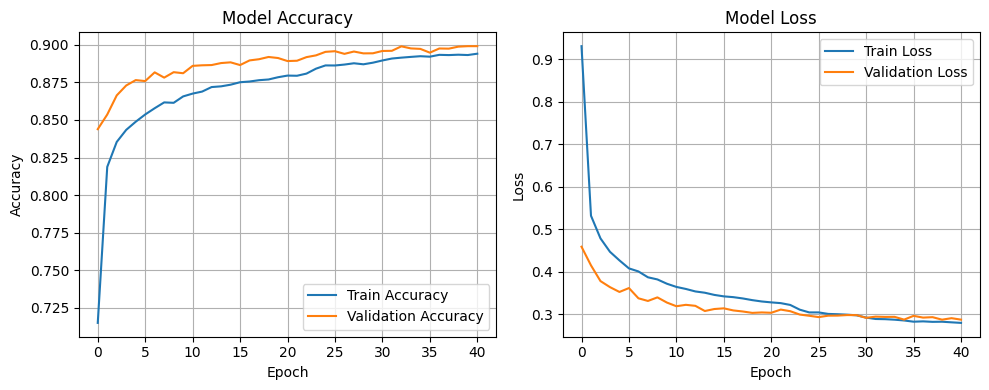

In [5]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

294/294 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step


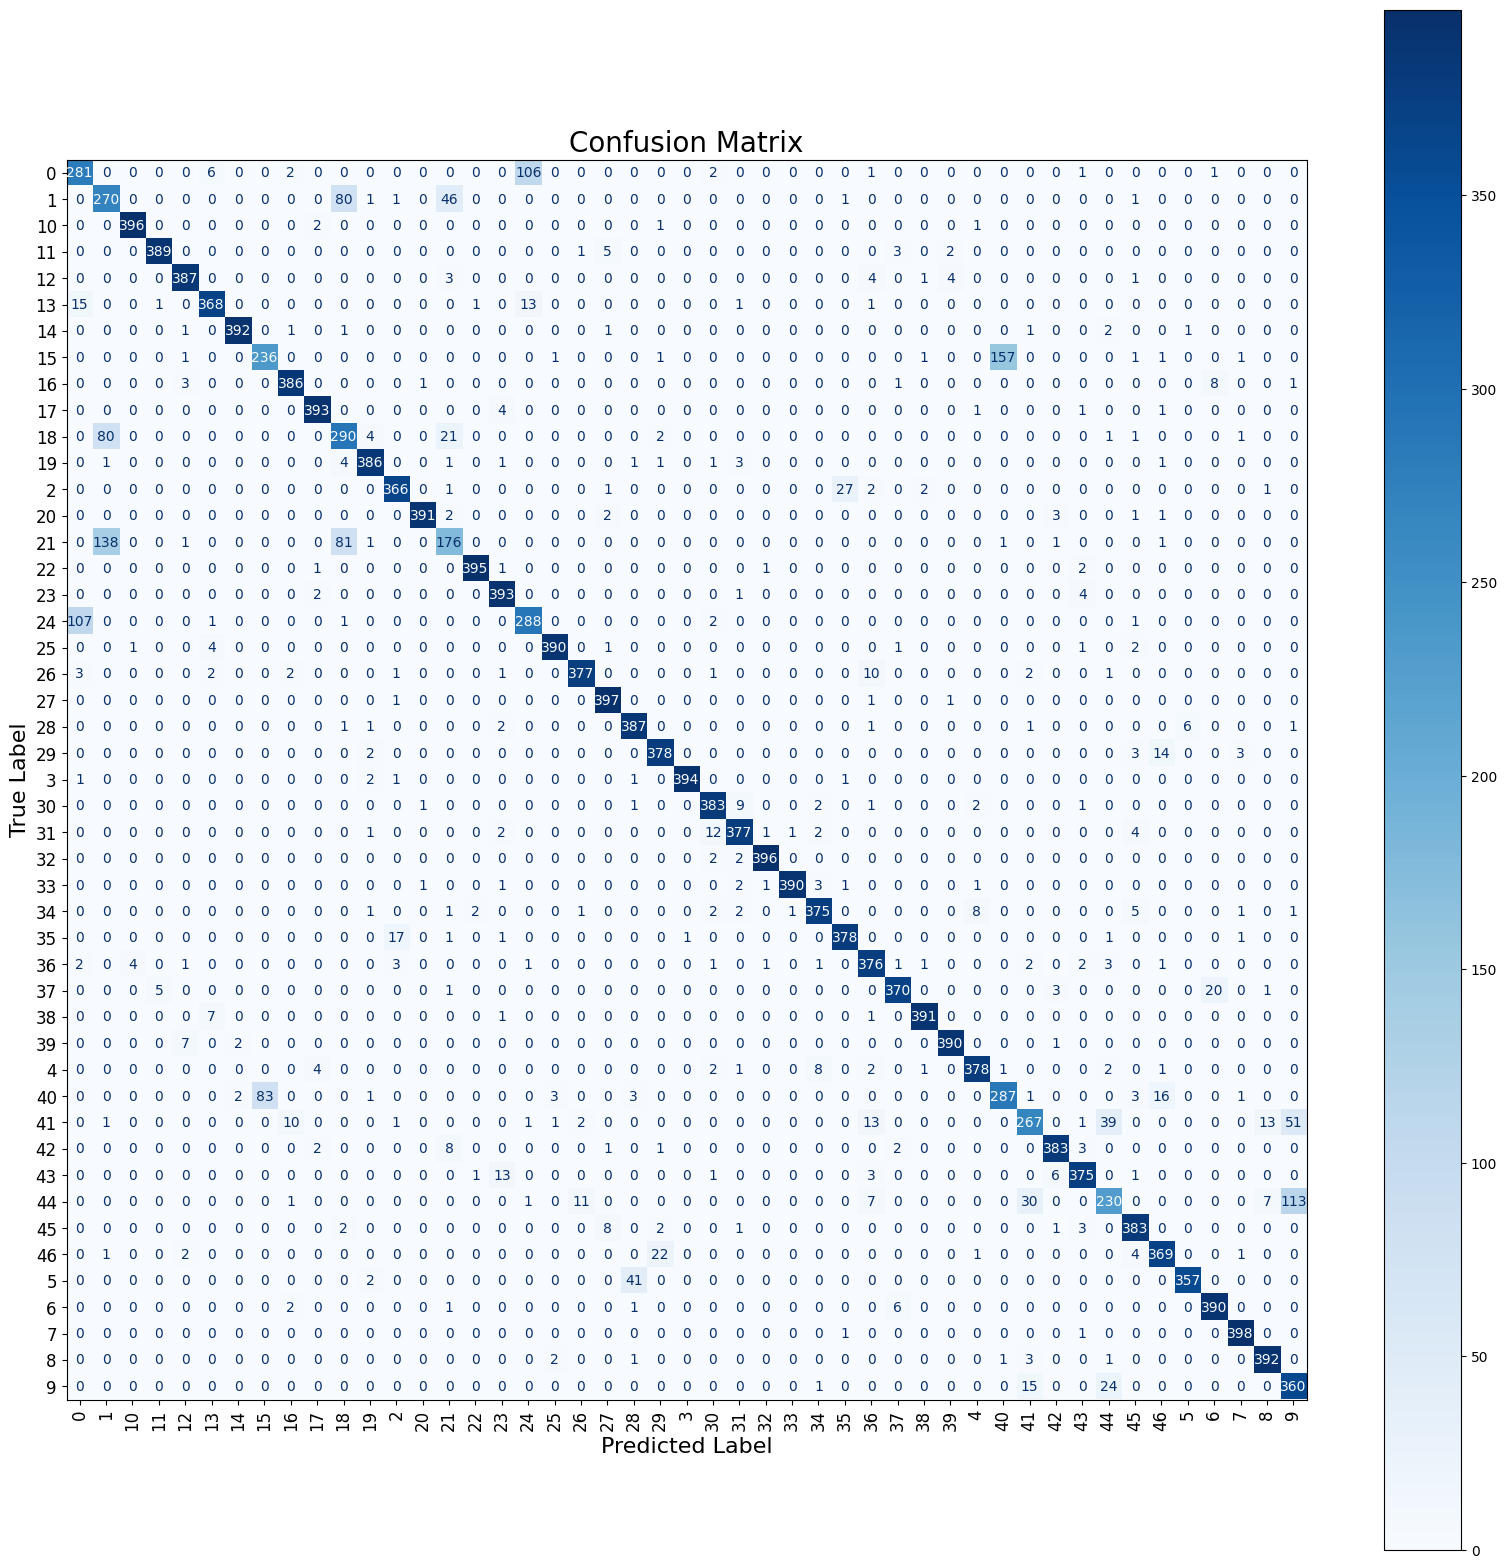

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

# Create large figure
fig, ax = plt.subplots(figsize=(20, 20))  # Adjust size as needed

# Display Confusion Matrix with custom axis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)

# Improve font sizes for visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)
plt.grid(False)

plt.show()


In [7]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Predict and true labels (already obtained previously)
y_pred_probs = model.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())

# Print classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("📋 Classification Report:\n")
print(report)

# Extract and print macro, weighted scores
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("🔢 Macro Scores")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")

print("\n🔢 Weighted Scores")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")


294/294 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step
📋 Classification Report:

              precision    recall  f1-score   support

           0     0.6872    0.6975    0.6923       400
           1     0.5409    0.6450    0.5884       400
          10     0.9875    0.9850    0.9862       400
          11     0.9848    0.9725    0.9786       400
          12     0.9652    0.9700    0.9676       400
          13     0.9485    0.9200    0.9340       400
          14     0.9849    0.9775    0.9812       400
          15     0.7242    0.5975    0.6548       400
          16     0.9630    0.9750    0.9689       400
          17     0.9776    0.9825    0.9800       400
          18     0.6266    0.7425    0.6796       400
          19     0.9721    0.9575    0.9647       400
           2     0.9239    0.9100    0.9169       400
          20     0.9949    0.9725    0.9836       400
          21     0.6566    0.4350    0.5233       400
          22     0.9875    0.9850    0.9862       400
          23 